# Motion with initial velocity <a class='tocSkip'></a>

Thomas Schanzer z5310829  
School of Physics, UNSW  
September 2021

In this notebook, we give the parcels some nonzero initial velocity and compare their motion to the zero-initial-velocity case.

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Dry-regime" data-toc-modified-id="Dry-regime-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Dry regime</a></span><ul class="toc-item"><li><span><a href="#Parcel-motion" data-toc-modified-id="Parcel-motion-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Parcel motion</a></span></li><li><span><a href="#Velocity-at-ground-impact" data-toc-modified-id="Velocity-at-ground-impact-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Velocity at ground impact</a></span></li><li><span><a href="#Time-to-reach-ground" data-toc-modified-id="Time-to-reach-ground-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Time to reach ground</a></span></li><li><span><a href="#Minimum-height" data-toc-modified-id="Minimum-height-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>Minimum height</a></span></li><li><span><a href="#Time-to-reach-minimum-height" data-toc-modified-id="Time-to-reach-minimum-height-1.5"><span class="toc-item-num">1.5&nbsp;&nbsp;</span>Time to reach minimum height</a></span></li></ul></li></ul></div>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import metpy.calc as mpcalc
import metpy.constants as const
from metpy.units import units
from metpy.units import concatenate
from metpy.plots import SkewT
from pint import UnitRegistry, set_application_registry

from scipy.optimize import root_scalar

from os import mkdir
from os.path import exists
import sys
import shelve

sys.path.append('../../scripts/')
from environment import Environment

In [17]:
set_application_registry(units)
fig_path = ('20210928_motion_with_initial_velocity_figures/')
if not exists(fig_path):
    mkdir(fig_path)
data_filename = '20210928_motion_with_initial_velocity_data'
zero_velocity_data_filename = (
    '../20210922_sounding_comparisons/20210922_sounding_comparisons_data')

In [7]:
file = '../../soundings/SYDNEY AIRPORT (94767) 12 Nov 2019 00Z.txt'
sounding = pd.read_csv(
    file, names=['pressure', 'temperature', 'dewpoint'],
    usecols=[0, 2, 3], header=0)
sounding = sounding.to_numpy()
pressure = sounding[:,0]*units.mbar
temperature = sounding[:,1]*units.celsius
dewpoint = sounding[:,2]*units.celsius
sydney = Environment(
    pressure, temperature, dewpoint,
    info='SYDNEY AIRPORT (94767) 12 Nov 2019 00Z', name='Sydney')

file = '../../soundings/48698 WSSS Singapore Observations at 00Z 02 Sep 2021.txt'
sounding = pd.read_fwf(
    file, names=['pressure', 'temperature', 'dewpoint'],
    usecols=[0, 2, 3], header=1)
sounding = sounding.to_numpy()
pressure = sounding[:,0]*units.mbar
temperature = sounding[:,1]*units.celsius
dewpoint = sounding[:,2]*units.celsius
singapore = Environment(
    pressure, temperature, dewpoint,
    info='48698 WSSS Singapore Observations at 00Z 02 Sep 2021',
    name='Singapore')

file = ('../../soundings/41217 OMAA Abu Dhabi Inter Arpt Observations at '
        '12Z 20 Sep 2021.txt')
sounding = pd.read_fwf(
    file, names=['pressure', 'temperature', 'dewpoint'],
    usecols=[0, 2, 3], header=1)
sounding = sounding.to_numpy()
pressure = sounding[:,0]*units.mbar
temperature = sounding[:,1]*units.celsius
dewpoint = sounding[:,2]*units.celsius
abu_dhabi = Environment(
    pressure, temperature, dewpoint,
    info='41217 OMAA Abu Dhabi Inter Arpt Observations at 12Z 20 Sep 2021',
    name='Abu Dhabi')

file = ('../../soundings/89564 Mawson Observations at 12Z 21 Sep 2021.txt')
sounding = pd.read_fwf(
    file, names=['pressure', 'temperature', 'dewpoint'],
    usecols=[0, 2, 3], header=1)
sounding = sounding.to_numpy()
pressure = sounding[:,0]*units.mbar
temperature = sounding[:,1]*units.celsius
dewpoint = sounding[:,2]*units.celsius
mawson = Environment(
    pressure, temperature, dewpoint,
    info='89564 Mawson Observations at 12Z 21 Sep 2021', name='Mawson')

In [8]:
# save sounding objects to file
with shelve.open(data_filename) as file:
    for sounding in [sydney, singapore, abu_dhabi, mawson]:
        file[sounding.name] = sounding

In [ ]:
# retrieve sounding objects from file
with shelve.open(data_filename) as file:
    sydney = file['Sydney']
    singapore = file['Singapore']
    abu_dhabi = file['Abu Dhabi']
    mawson = file['Mawson']

## Dry regime

In [10]:
initial_velocity_down = {}
initial_height = 3*units.km
initial_velocity = -1*units.meter/units.second
dq = {}
time = np.arange(0, 9*60, 15)*units.second
for sounding in [sydney, singapore, abu_dhabi, mawson]:
    print('Calculating for {}:'.format(sounding.name))
    max_dq = sounding.maximum_specific_humidity_change(initial_height)
    dq[sounding.name] = np.arange(0, max_dq*1.001, max_dq/40)
    initial_height_array = np.ones(
        len(dq[sounding.name]))*initial_height
    initial_velocity_array = np.ones(
        len(dq[sounding.name]))*initial_velocity
    initial_velocity_down[sounding.name] = sounding.modified_motion(
        time, initial_height_array, initial_velocity_array, dq[sounding.name],
        regime='dry')
    sys.stdout.write('\n')

Calculating for Sydney:
Calculating profile 41 of 41.   
Calculating for Singapore:
Calculating profile 41 of 41.   
Calculating for Abu Dhabi:
Calculating profile 41 of 41.   
Calculating for Mawson:
Calculating profile 41 of 41.   


In [12]:
# save to file
with shelve.open(data_filename) as file:
    file['dry_motion_3km_-1m/s'] = {
        'dq': dq, 'time': time, 'motion': initial_velocity_down}

In [13]:
# retrieve from file
with shelve.open(data_filename) as file:
    dq = file['dry_motion_3km_-1m/s']['dq']
    time = file['dry_motion_3km_-1m/s']['time']
    initial_velocity_down = file['dry_motion_3km_-1m/s']['motion']

In [14]:
initial_velocity_up = {}
initial_height = 3*units.km
initial_velocity = 1*units.meter/units.second
dq = {}
time = np.arange(0, 9*60, 15)*units.second
for sounding in [sydney, singapore, abu_dhabi, mawson]:
    print('Calculating for {}:'.format(sounding.name))
    max_dq = sounding.maximum_specific_humidity_change(initial_height)
    dq[sounding.name] = np.arange(0, max_dq*1.001, max_dq/40)
    initial_height_array = np.ones(
        len(dq[sounding.name]))*initial_height
    initial_velocity_array = np.ones(
        len(dq[sounding.name]))*initial_velocity
    initial_velocity_up[sounding.name] = sounding.modified_motion(
        time, initial_height_array, initial_velocity_array, dq[sounding.name],
        regime='dry')
    sys.stdout.write('\n')

Calculating for Sydney:
Calculating profile 41 of 41.   
Calculating for Singapore:
Calculating profile 41 of 41.   
Calculating for Abu Dhabi:
Calculating profile 41 of 41.   
Calculating for Mawson:
Calculating profile 41 of 41.   


In [15]:
# save to file
with shelve.open(data_filename) as file:
    file['dry_motion_3km_+1m/s'] = {
        'dq': dq, 'time': time, 'motion': initial_velocity_up}

In [13]:
# retrieve from file
with shelve.open(data_filename) as file:
    dq = file['dry_motion_3km_+1m/s']['dq']
    time = file['dry_motion_3km_+1m/s']['time']
    initial_velocity_up = file['dry_motion_3km_+1m/s']['motion']

In [18]:
# zero velocity data
with shelve.open(zero_velocity_data_filename) as file:
    initial_velocity_zero = file['dry_motion_3km']['dry_motion_3km']

### Parcel motion

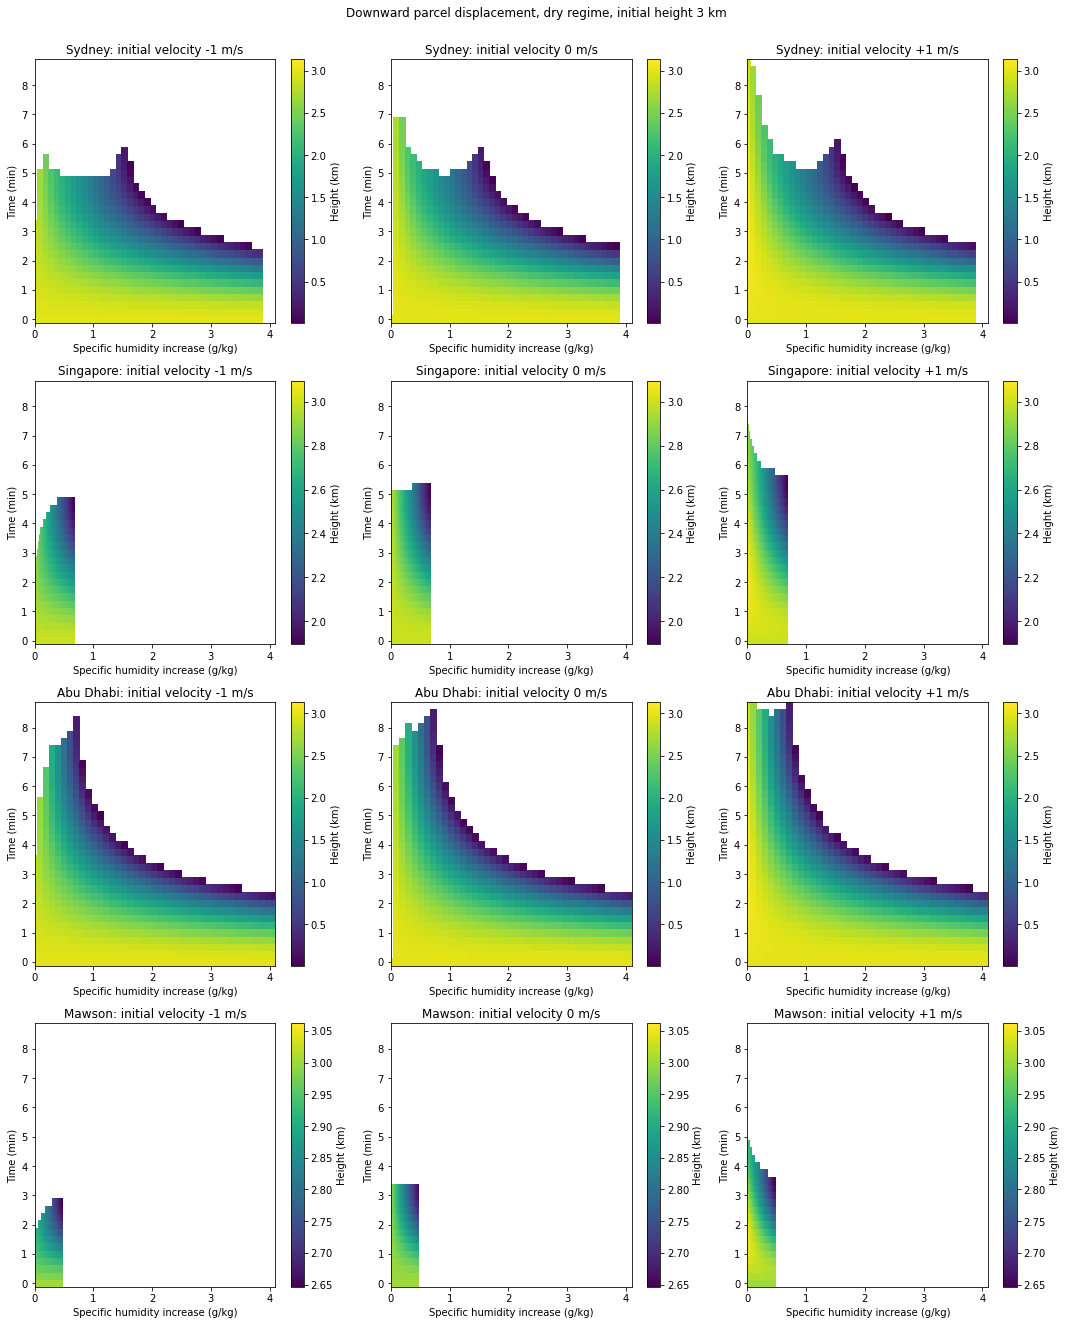

In [45]:
fig = plt.figure(figsize=(15,18))
time = np.arange(0, 9*60, 15)*units.second

for i, sounding in enumerate([sydney, singapore, abu_dhabi, mawson]):
    min_height = np.min([
        np.nanmin(initial_velocity_down[sounding.name].height).m,
        np.nanmin(initial_velocity_zero[sounding.name].height).m,
        np.nanmin(initial_velocity_up[sounding.name].height).m,
    ])/1e3
    max_height = np.max([
        np.nanmax(initial_velocity_down[sounding.name].height).m,
        np.nanmax(initial_velocity_zero[sounding.name].height).m,
        np.nanmax(initial_velocity_up[sounding.name].height).m,
    ])/1e3
    
    ax1 = fig.add_subplot(4, 3, 1+3*i)
    mesh = ax1.pcolormesh(
        dq[sounding.name]*1e3, time/60, 
        initial_velocity_down[sounding.name].height.T/1e3,
        vmin=min_height, vmax=max_height, shading='nearest')
    cbar = plt.colorbar(mesh)
    cbar.set_label('Height (km)')
    ax1.set(
        xlabel='Specific humidity increase (g/kg)',
        ylabel='Time (min)',
        title='{}: initial velocity -1 m/s'.format(sounding.name))
#     ax1.set_ylim(0, 9)
    ax1.set_xlim(0,4.1)
    
    ax1 = fig.add_subplot(4, 3, 2+3*i)
    mesh = ax1.pcolormesh(
        dq[sounding.name]*1e3, time/60, 
        initial_velocity_zero[sounding.name].height.T/1e3,
        vmin=min_height, vmax=max_height, shading='nearest')
    cbar = plt.colorbar(mesh)
    cbar.set_label('Height (km)')
    ax1.set(
        xlabel='Specific humidity increase (g/kg)',
        ylabel='Time (min)',
        title='{}: initial velocity 0 m/s'.format(sounding.name))
#     ax1.set_ylim(0, 9)
    ax1.set_xlim(0,4.1)
    
    ax1 = fig.add_subplot(4, 3, 3+3*i)
    mesh = ax1.pcolormesh(
        dq[sounding.name]*1e3, time/60, 
        initial_velocity_up[sounding.name].height.T/1e3,
        vmin=min_height, vmax=max_height, shading='nearest')
    cbar = plt.colorbar(mesh)
    cbar.set_label('Height (km)')
    ax1.set(
        xlabel='Specific humidity increase (g/kg)',
        ylabel='Time (min)',
        title='{}: initial velocity +1 m/s'.format(sounding.name))
#     ax1.set_ylim(0, 9)
    ax1.set_xlim(0,4.1)


fig.tight_layout()
fig.suptitle('Downward parcel displacement, dry regime, initial height 3 km',
             y=1.02)
fig.savefig(
    fig_path + 'dry_displacement_3km_comparison.png', dpi=300, facecolor='w',
    bbox_inches='tight')
plt.show()

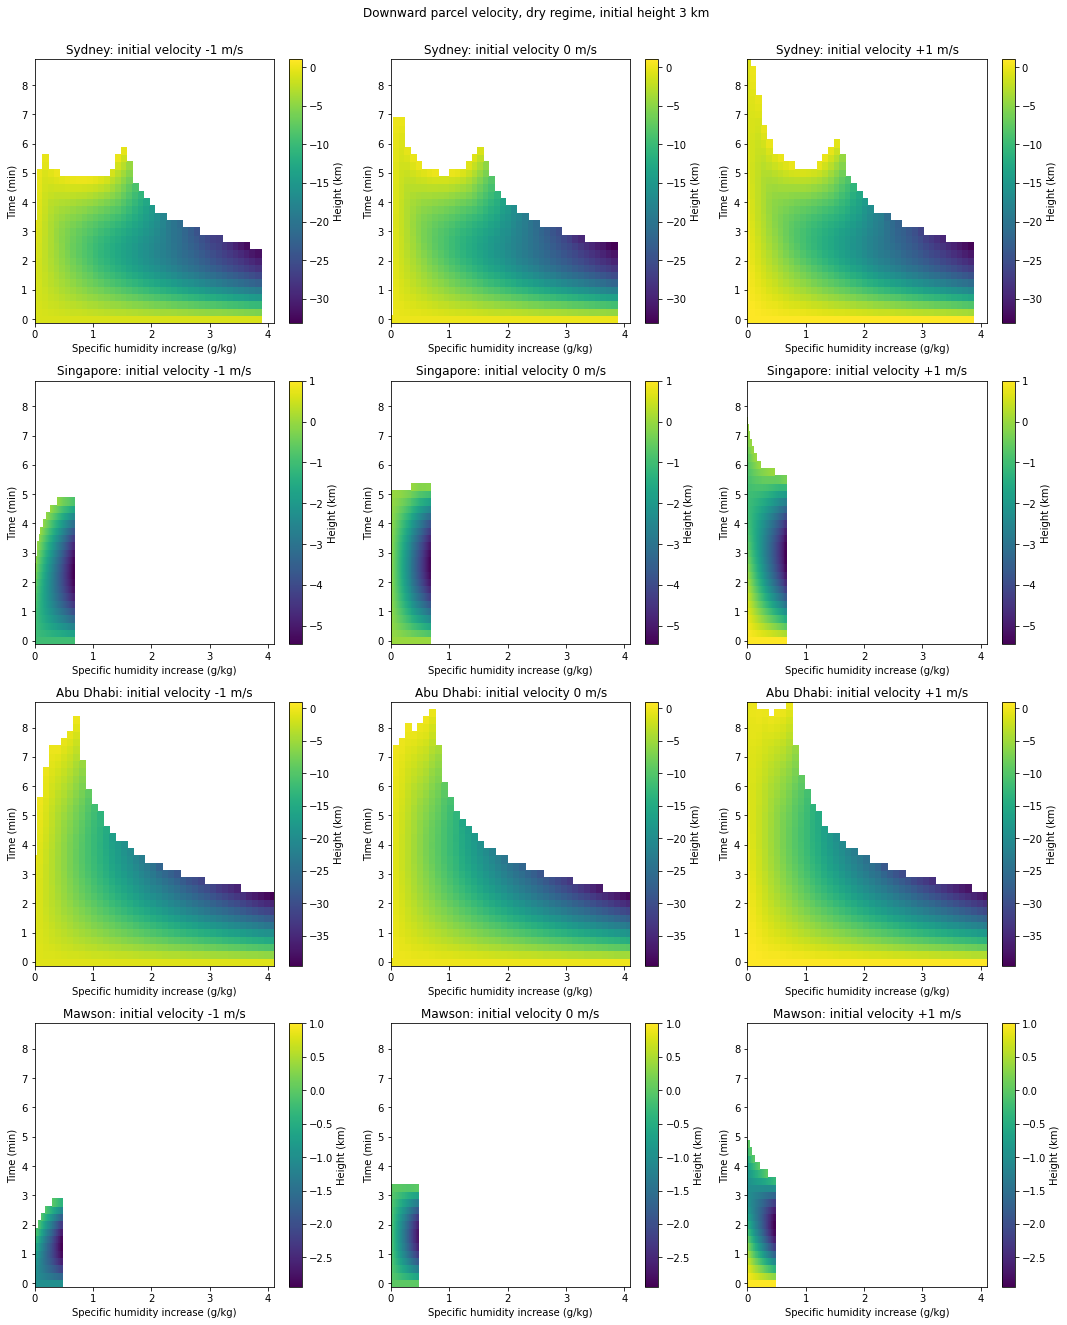

In [47]:
fig = plt.figure(figsize=(15,18))

for i, sounding in enumerate([sydney, singapore, abu_dhabi, mawson]):
    min_velocity = np.min([
        np.nanmin(initial_velocity_down[sounding.name].velocity).m,
        np.nanmin(initial_velocity_zero[sounding.name].velocity).m,
        np.nanmin(initial_velocity_up[sounding.name].velocity).m,
    ])
    max_velocity = np.max([
        np.nanmax(initial_velocity_down[sounding.name].velocity).m,
        np.nanmax(initial_velocity_zero[sounding.name].velocity).m,
        np.nanmax(initial_velocity_up[sounding.name].velocity).m,
    ])
    
    ax1 = fig.add_subplot(4, 3, 1+3*i)
    mesh = ax1.pcolormesh(
        dq[sounding.name]*1e3, time/60, 
        initial_velocity_down[sounding.name].velocity.T,
        vmin=min_velocity, vmax=max_velocity, shading='nearest')
    cbar = plt.colorbar(mesh)
    cbar.set_label('Height (km)')
    ax1.set(
        xlabel='Specific humidity increase (g/kg)',
        ylabel='Time (min)',
        title='{}: initial velocity -1 m/s'.format(sounding.name))
#     ax1.set_ylim(0, 9)
    ax1.set_xlim(0,4.1)
    
    ax1 = fig.add_subplot(4, 3, 2+3*i)
    mesh = ax1.pcolormesh(
        dq[sounding.name]*1e3, time/60, 
        initial_velocity_zero[sounding.name].velocity.T,
        vmin=min_velocity, vmax=max_velocity, shading='nearest')
    cbar = plt.colorbar(mesh)
    cbar.set_label('Height (km)')
    ax1.set(
        xlabel='Specific humidity increase (g/kg)',
        ylabel='Time (min)',
        title='{}: initial velocity 0 m/s'.format(sounding.name))
#     ax1.set_ylim(0, 9)
    ax1.set_xlim(0,4.1)
    
    ax1 = fig.add_subplot(4, 3, 3+3*i)
    mesh = ax1.pcolormesh(
        dq[sounding.name]*1e3, time/60, 
        initial_velocity_up[sounding.name].velocity.T,
        vmin=min_velocity, vmax=max_velocity, shading='nearest')
    cbar = plt.colorbar(mesh)
    cbar.set_label('Height (km)')
    ax1.set(
        xlabel='Specific humidity increase (g/kg)',
        ylabel='Time (min)',
        title='{}: initial velocity +1 m/s'.format(sounding.name))
#     ax1.set_ylim(0, 9)
    ax1.set_xlim(0,4.1)


fig.tight_layout()
fig.suptitle('Downward parcel velocity, dry regime, initial height 3 km',
             y=1.02)
fig.savefig(
    fig_path + 'dry_velocity_3km_comparison.png', dpi=300, facecolor='w',
    bbox_inches='tight')
plt.show()

### Velocity at ground impact

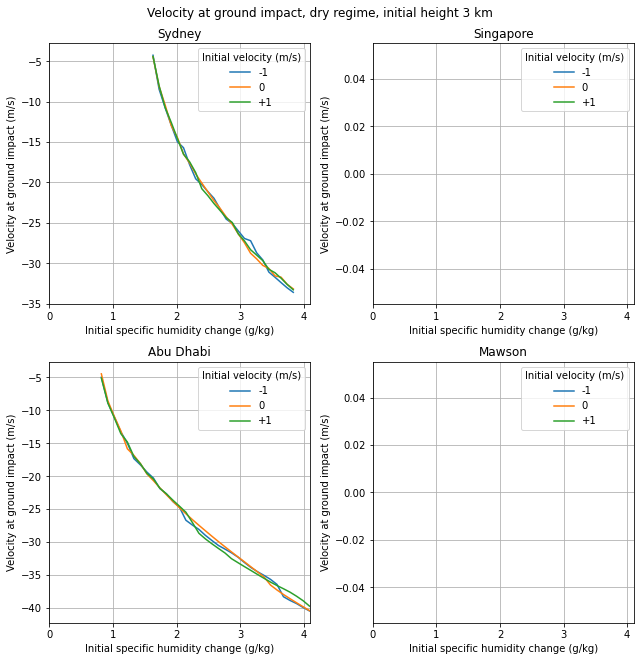

In [51]:
fig = plt.figure(figsize=(9,9))

for i, sounding in enumerate([sydney, singapore, abu_dhabi, mawson]):
    ax = fig.add_subplot(221+i)
    ax.plot(
        dq[sounding.name]*1e3,
        initial_velocity_down[sounding.name].hit_ground_velocity,
        label='-1')
    ax.plot(
        dq[sounding.name]*1e3,
        initial_velocity_zero[sounding.name].hit_ground_velocity,
        label='0')
    ax.plot(
        dq[sounding.name]*1e3,
        initial_velocity_up[sounding.name].hit_ground_velocity,
        label='+1')
    lgd = ax.legend()
    lgd.set_title('Initial velocity (m/s)')
    ax.set_xlim(0, 4.1)
    ax.set(
        xlabel='Initial specific humidity change (g/kg)',
        ylabel='Velocity at ground impact (m/s)',
        title=sounding.name)
    ax.grid()
fig.tight_layout()
fig.suptitle(
    'Velocity at ground impact, dry regime, initial height 3 km', y=1.015)
fig.savefig(
    fig_path + 'dry_ground_impact_velocity_3km_comparison.png',
    dpi=300, facecolor='w', bbox_inches='tight')
plt.show()

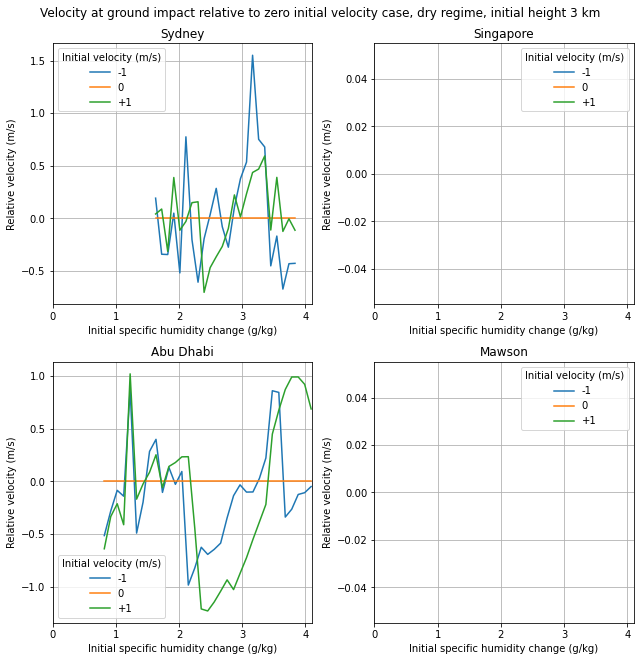

In [77]:
fig = plt.figure(figsize=(9,9))

for i, sounding in enumerate([sydney, singapore, abu_dhabi, mawson]):
    ax = fig.add_subplot(221+i)
    ax.plot(
        dq[sounding.name]*1e3,
        (initial_velocity_down[sounding.name].hit_ground_velocity
         - initial_velocity_zero[sounding.name].hit_ground_velocity),
        label='-1')
    ax.plot(
        dq[sounding.name]*1e3,
        (initial_velocity_zero[sounding.name].hit_ground_velocity
         - initial_velocity_zero[sounding.name].hit_ground_velocity),
        label='0')
    ax.plot(
        dq[sounding.name]*1e3,
        (initial_velocity_up[sounding.name].hit_ground_velocity
         - initial_velocity_zero[sounding.name].hit_ground_velocity),
        label='+1')
    lgd = ax.legend()
    lgd.set_title('Initial velocity (m/s)')
    ax.set_xlim(0, 4.1)
    ax.set(
        xlabel='Initial specific humidity change (g/kg)',
        ylabel='Relative velocity (m/s)',
        title=sounding.name)
    ax.grid()
fig.tight_layout()
fig.suptitle(
    'Velocity at ground impact relative to zero initial velocity case, '
    'dry regime, initial height 3 km', y=1.015)
fig.savefig(
    fig_path + 'dry_ground_impact_velocity_3km_comparison_relative.png',
    dpi=300, facecolor='w', bbox_inches='tight')
plt.show()

### Time to reach ground

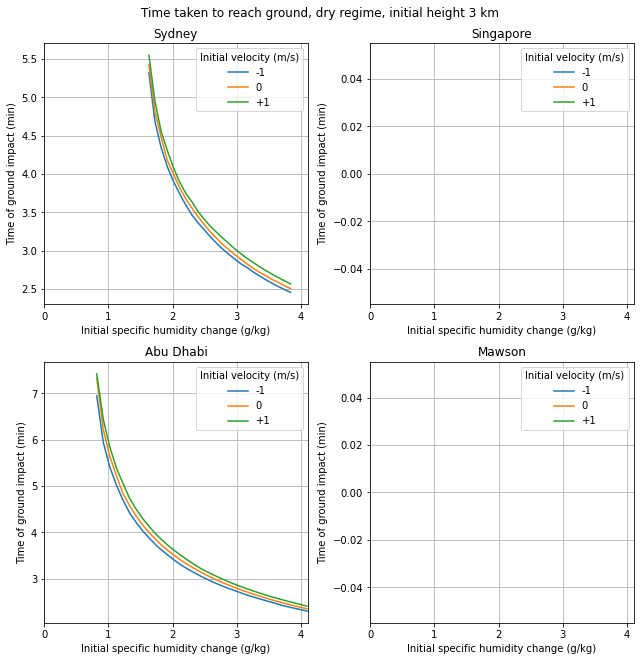

In [55]:
fig = plt.figure(figsize=(9,9))

for i, sounding in enumerate([sydney, singapore, abu_dhabi, mawson]):
    ax = fig.add_subplot(221+i)
    ax.plot(
        dq[sounding.name]*1e3,
        initial_velocity_down[sounding.name].hit_ground_time.to(units.min),
        label='-1')
    ax.plot(
        dq[sounding.name]*1e3,
        initial_velocity_zero[sounding.name].hit_ground_time.to(units.min),
        label='0')
    ax.plot(
        dq[sounding.name]*1e3,
        initial_velocity_up[sounding.name].hit_ground_time.to(units.min),
        label='+1')
    lgd = ax.legend()
    lgd.set_title('Initial velocity (m/s)')
    ax.set_xlim(0, 4.1)
    ax.set(
        xlabel='Initial specific humidity change (g/kg)',
        ylabel='Time of ground impact (min)',
        title=sounding.name)
    ax.grid()
fig.tight_layout()
fig.suptitle(
    'Time taken to reach ground, dry regime, initial height 3 km', y=1.015)
fig.savefig(
    fig_path + 'dry_ground_impact_time_3km_comparison.png',
    dpi=300, facecolor='w', bbox_inches='tight')
plt.show()

### Minimum height

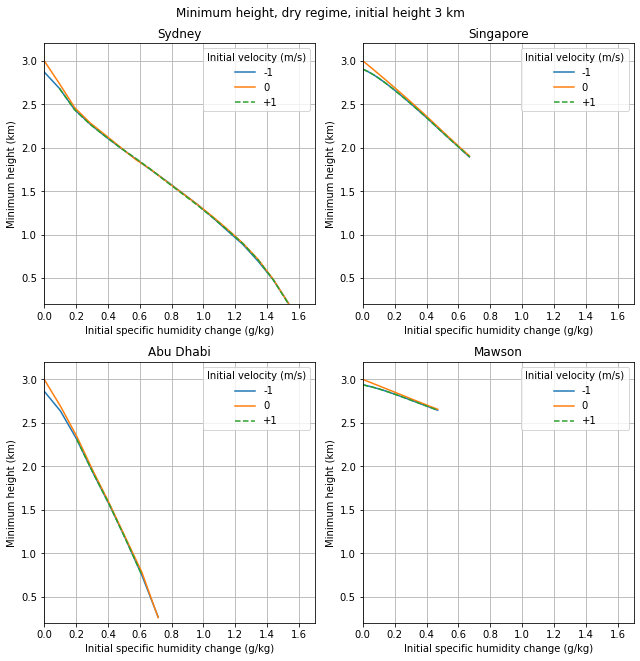

In [73]:
fig = plt.figure(figsize=(9,9))

for i, sounding in enumerate([sydney, singapore, abu_dhabi, mawson]):
    ax = fig.add_subplot(221+i)
    ax.plot(
        dq[sounding.name]*1e3,
        initial_velocity_down[sounding.name].min_height.to(units.km),
        label='-1')
    ax.plot(
        dq[sounding.name]*1e3,
        initial_velocity_zero[sounding.name].min_height.to(units.km),
        label='0')
    ax.plot(
        dq[sounding.name]*1e3,
        initial_velocity_up[sounding.name].min_height.to(units.km), '--',
        label='+1')
    lgd = ax.legend()
    lgd.set_title('Initial velocity (m/s)')
    ax.set_xlim(0, 1.7)
    ax.set_ylim(0.2, 3.2)
    ax.set(
        xlabel='Initial specific humidity change (g/kg)',
        ylabel='Minimum height (km)',
        title=sounding.name)
    ax.grid()
fig.tight_layout()
fig.suptitle(
    'Minimum height, dry regime, initial height 3 km',
    y=1.015)
fig.savefig(
    fig_path + 'dry_min_height_3km_comparison.png',
    dpi=300, facecolor='w', bbox_inches='tight')
plt.show()

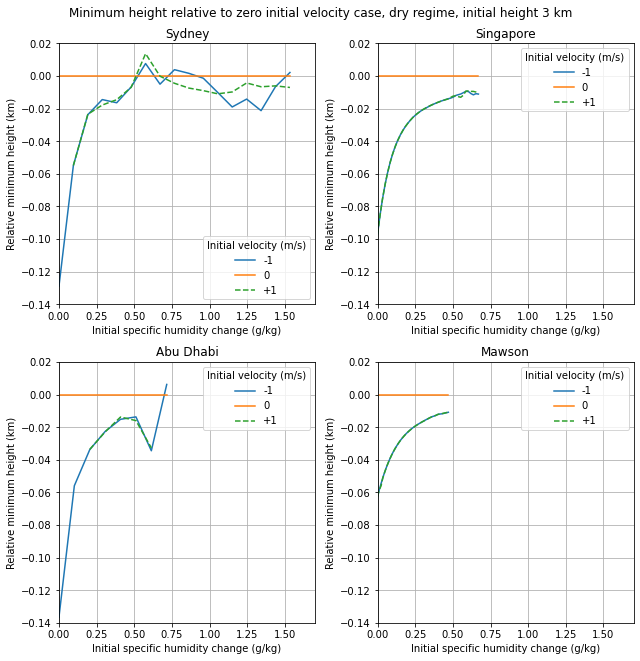

In [78]:
fig = plt.figure(figsize=(9,9))

for i, sounding in enumerate([sydney, singapore, abu_dhabi, mawson]):
    ax = fig.add_subplot(221+i)
    ax.plot(
        dq[sounding.name]*1e3,
        (initial_velocity_down[sounding.name].min_height.to(units.km)
         - initial_velocity_zero[sounding.name].min_height.to(units.km)),
        label='-1')
    ax.plot(
        dq[sounding.name]*1e3,
        (initial_velocity_zero[sounding.name].min_height.to(units.km)
         - initial_velocity_zero[sounding.name].min_height.to(units.km)),
        label='0')
    ax.plot(
        dq[sounding.name]*1e3,
        (initial_velocity_up[sounding.name].min_height.to(units.km)
         - initial_velocity_zero[sounding.name].min_height.to(units.km)), '--',
        label='+1')
    lgd = ax.legend()
    lgd.set_title('Initial velocity (m/s)')
    ax.set_xlim(0, 1.7)
    ax.set_ylim(-0.14, 0.02)
    ax.set(
        xlabel='Initial specific humidity change (g/kg)',
        ylabel='Relative minimum height (km)',
        title=sounding.name)
    ax.grid()
fig.tight_layout()
fig.suptitle(
    'Minimum height relative to zero initial velocity case, dry regime, '
    'initial height 3 km', y=1.015)
fig.savefig(
    fig_path + 'dry_min_height_3km_comparison_relative.png',
    dpi=300, facecolor='w', bbox_inches='tight')
plt.show()

### Time to reach minimum height

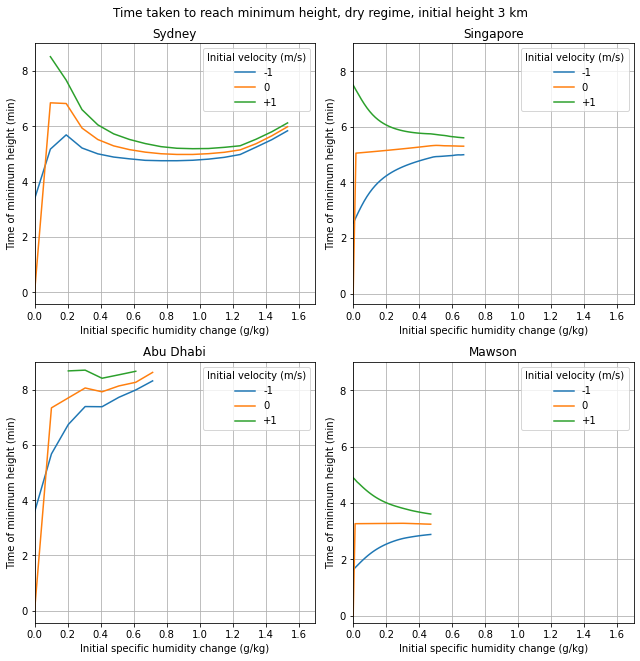

In [61]:
fig = plt.figure(figsize=(9,9))

for i, sounding in enumerate([sydney, singapore, abu_dhabi, mawson]):
    ax = fig.add_subplot(221+i)
    ax.plot(
        dq[sounding.name]*1e3,
        initial_velocity_down[sounding.name].min_height_time.to(units.min),
        label='-1')
    ax.plot(
        dq[sounding.name]*1e3,
        initial_velocity_zero[sounding.name].min_height_time.to(units.min),
        label='0')
    ax.plot(
        dq[sounding.name]*1e3,
        initial_velocity_up[sounding.name].min_height_time.to(units.min),
        label='+1')
    lgd = ax.legend()
    lgd.set_title('Initial velocity (m/s)')
    ax.set_xlim(0, 1.7)
    ax.set_ylim(top=9)
    ax.set(
        xlabel='Initial specific humidity change (g/kg)',
        ylabel='Time of minimum height (min)',
        title=sounding.name)
    ax.grid()
fig.tight_layout()
fig.suptitle(
    'Time taken to reach minimum height, dry regime, initial height 3 km',
    y=1.015)
fig.savefig(
    fig_path + 'dry_min_height_time_3km_comparison.png',
    dpi=300, facecolor='w', bbox_inches='tight')
plt.show()